In [16]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [24]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

def get_stock_data(ticker, start_date, end_date):
    # Fetch the stock data
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, end=end_date)
    
    # Reset index to make Date a column
    df = df.reset_index()
    
    # Rename columns
    df = df.rename(columns={
        'Date': 'date',
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Volume': 'volume'
    })
    
    # Select only the columns we need
    df = df[['date', 'open', 'high', 'low', 'close', 'volume']]
    
    return df

# Set the stock ticker, start date, and end date
ticker = 'MSFT'  # Apple Inc.
end_date = datetime.now()
start_date = end_date - timedelta(days=365)  # Data for the past year

# Get the stock data
df = get_stock_data(ticker, start_date, end_date)

# Display the first few rows of the DataFrame
print(df.head())

# Basic statistics of the data
print(df.describe())

# Save to CSV (optional)
df.to_csv(f'{ticker}_stock_data.csv', index=False)

                       date        open        high         low       close  \
0 2023-09-08 00:00:00-04:00  327.630751  333.655536  327.005440  331.779602   
1 2023-09-11 00:00:00-04:00  334.727505  335.898737  332.930992  335.422302   
2 2023-09-12 00:00:00-04:00  333.318093  334.280868  329.010431  329.298248   
3 2023-09-13 00:00:00-04:00  328.841723  334.340458  328.702782  333.556335   
4 2023-09-14 00:00:00-04:00  336.623265  338.320517  334.062500  336.176636   

     volume  
0  19530100  
1  16583300  
2  17565500  
3  16544400  
4  20267000  
             open        high         low       close        volume
count  251.000000  251.000000  251.000000  251.000000  2.510000e+02
mean   394.561850  397.610139  391.080852  394.548575  2.203710e+07
std     38.373438   38.387922   38.073299   38.289651  8.079345e+06
min    308.673094  311.958416  307.144589  309.814514  9.932800e+06
25%    369.366280  372.379836  366.840115  370.833282  1.679990e+07
50%    406.492796  408.925128  40

In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assume 'df' is your DataFrame with stock data
# and 'close' is the column with closing prices

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))

# Define the lookback period
lookback = 60  # For example, use 60 days of historical data to predict the next day

# Prepare X and y
X = []
y = []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape X to fit LSTM input shape: (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [20]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (152, 60, 1)
y_train shape: (152,)


In [26]:
# Assuming X_train shape is (samples, time_steps, 1)
time_steps = X_train.shape[1]
features = X_train.shape[2]

model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(time_steps, features)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.4393 - val_loss: 0.2612
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0514 - val_loss: 0.0042
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0397 - val_loss: 0.0175
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0106 - val_loss: 0.0681
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0155 - val_loss: 0.0570
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0086 - val_loss: 0.0264
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0109 - val_loss: 0.0165
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0090 - val_loss: 0.0242
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0068 - val_loss: 0.0290
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0123 - val_loss: 0.0241
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0089 - val_loss: 0.0157
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0099 - val_lo

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x159922480> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


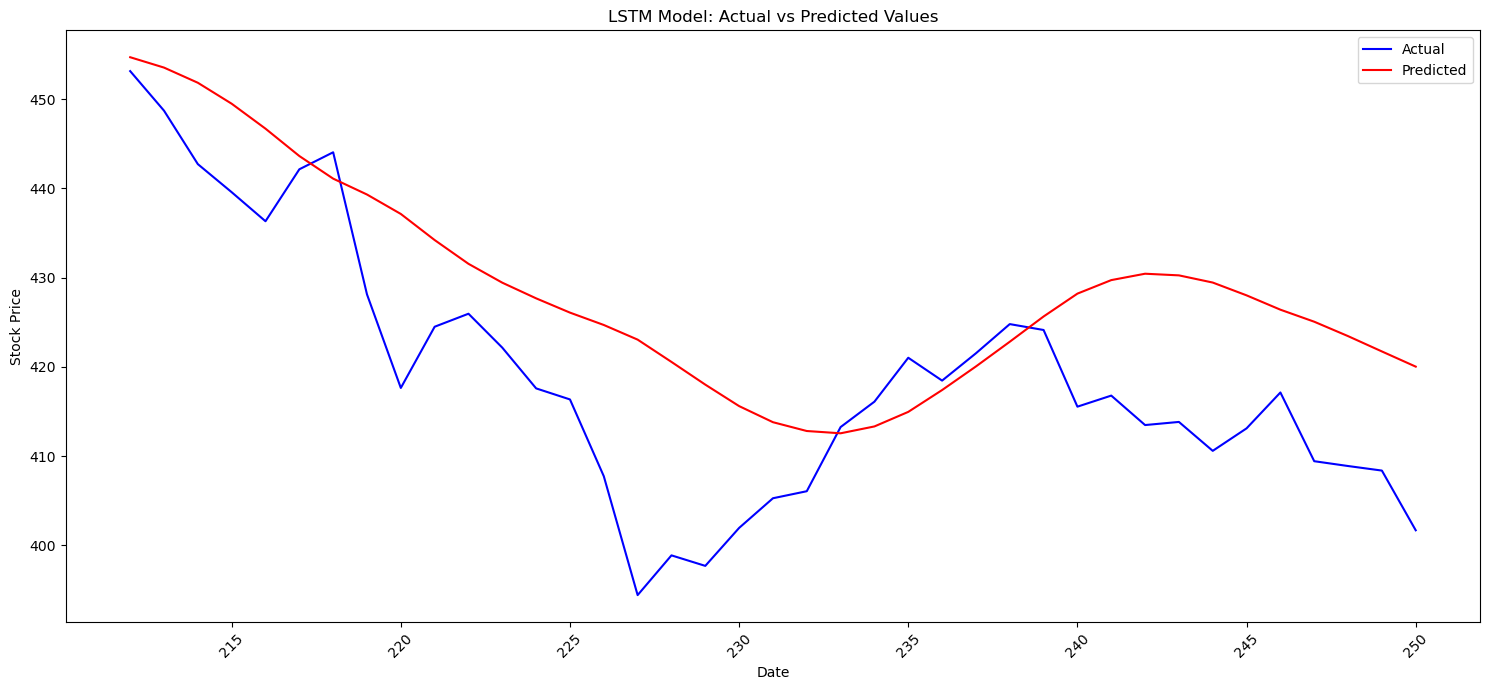

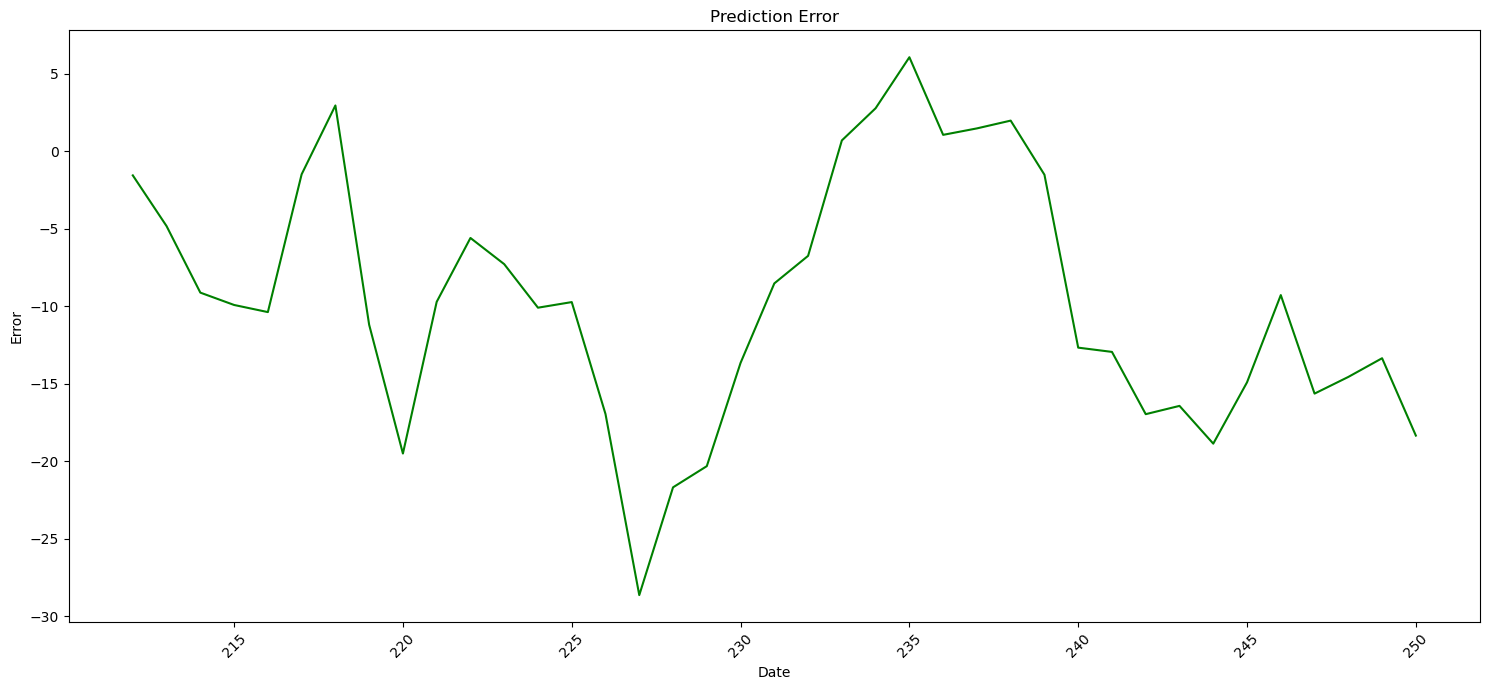

Mean Squared Error: 155.6821
Mean Absolute Error: 10.4920
Root Mean Squared Error: 12.4773


In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you've already trained your model and have X_test and y_test

# Make predictions
predictions = model.predict(X_test)

# If you used a scaler, inverse transform the predictions and actual values
if 'scaler' in locals():
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame(data={'Actual': y_test.flatten(), 'Predicted': predictions.flatten()})
results_df.index = df.index[-len(results_df):]  # Assuming df is your original DataFrame

# Plot the results
plt.figure(figsize=(15, 7))
plt.plot(results_df.index, results_df['Actual'], label='Actual', color='blue')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted', color='red')
plt.title('LSTM Model: Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the error
plt.figure(figsize=(15, 7))
plt.plot(results_df.index, results_df['Actual'] - results_df['Predicted'], color='green')
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print some error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(results_df['Actual'], results_df['Predicted'])
mae = mean_absolute_error(results_df['Actual'], results_df['Predicted'])
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")